# Basics

In [14]:
import jax
import jax.numpy as jnp
from jax import jit

x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


In [5]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])
y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

print("gradients for both:", jax.grad(sum_squared_error, argnums=(0, 1))(x, y))  # Find gradient wrt both x & y

print("value and grad:", jax.value_and_grad(sum_squared_error)(x, y)) # value and grad

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]
gradients for both: (DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32), DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))
value and grad: (DeviceArray(0.03999995, dtype=float32), DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))


In [9]:
def squared_error_with_aux(x, y):
  return sum_squared_error(x, y), x-y # PAIR of (out,aux)

# jax.grad(squared_error_with_aux)(x, y) # error
jax.grad(squared_error_with_aux, has_aux=True)(x, y) # return grad, aux (without grad)

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

In [10]:
def jax_in_place_modify(x):
  return x.at[0].set(123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

DeviceArray([123,   2,   3], dtype=int32)

### Training loop

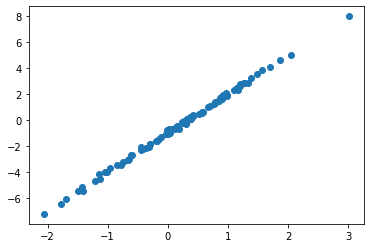

In [17]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)

In [22]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

@jit
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 3.00, b: -0.99


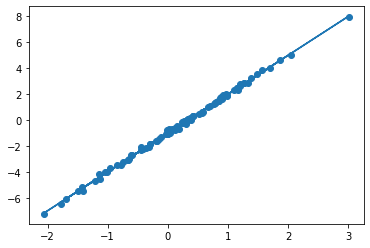

In [23]:
theta = jnp.array([1., 1.]) # init param

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

# JIT

In [ ]:
from functools import partial

def unjitted_loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted_partial(x, n):
  i = 0
  while i < n:
    # Don't do this! each time the partial returns
    # a function with different hash
    i = jax.jit(partial(unjitted_loop_body))(i)
  return x + i

def g_inner_jitted_lambda(x, n):
  i = 0
  while i < n:
    # Don't do this!, lambda will also return
    # a function with a different hash
    i = jax.jit(lambda x: unjitted_loop_body(x))(i)
  return x + i

def g_inner_jitted_normal(x, n):
  i = 0
  while i < n:
    # this is OK, since JAX can find the
    # cached, compiled function
    i = jax.jit(unjitted_loop_body)(i)
  return x + i

print("jit called in a loop with partials:")
%timeit g_inner_jitted_partial(10, 20).block_until_ready()

print("jit called in a loop with lambdas:")
%timeit g_inner_jitted_lambda(10, 20).block_until_ready()

print("jit called in a loop with caching:")
%timeit g_inner_jitted_normal(10, 20).block_until_ready()

# VMAP

In [24]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

DeviceArray([11., 20., 29.], dtype=float32)

In [40]:
# Manual Batch convolve vectorized
def manually_vectorized_convolve(xs, ws):
  output = []
  for i in range(1, xs.shape[-1] -1):
    output.append(jnp.sum(xs[:, i-1:i+2] * ws, axis=1))
  return jnp.stack(output, axis=1)

xs = jnp.stack([x, x])
ws = jnp.stack([w, w])
print(manually_vectorized_convolve(xs, ws))
%timeit manually_vectorized_convolve(xs, ws)
%timeit jax.jit(manually_vectorized_convolve)(xs, ws)

[[11. 20. 29.]
 [11. 20. 29.]]
2.62 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
74 µs ± 7.33 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [31]:
# auto vectorization
auto_batch_convolve = jax.vmap(convolve)

print(auto_batch_convolve(xs, ws)) # both inputs are batches
%timeit auto_batch_convolve(xs, ws)

[[11. 20. 29.]
 [11. 20. 29.]]
5.69 ms ± 95.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
# vectorize 2nd axis
auto_batch_convolve_v2 = jax.vmap(convolve, in_axes=1, out_axes=1)
xst = jnp.transpose(xs)
wst = jnp.transpose(ws)
print(auto_batch_convolve_v2(xst, wst))

# vectorize 1 input
batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])
print(batch_convolve_v3(xs, w))

[[11. 11.]
 [20. 20.]
 [29. 29.]]
[[11. 20. 29.]
 [11. 20. 29.]]


In [39]:
jitted_batch_convolve = jax.jit(auto_batch_convolve)

%timeit jitted_batch_convolve(xs, ws) # comparable with jitted manual vectorization

50.2 µs ± 7.37 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# GRAD
https://www.youtube.com/watch?v=wG_nF1awSSY&ab_channel=AriSeff

In [41]:
import jax
import jax.numpy as jnp

f = lambda x: x**3 + 2*x**2 - 3*x + 1

dfdx = jax.grad(f)
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)
d4fdx = jax.grad(d3fdx)

In [43]:
def hessian(f):
  return jax.jacfwd(jax.grad(f))

def f(x):
  return jnp.dot(x, x)

hessian(f)(jnp.array([1., 25., 3.]))

DeviceArray([[2., 0., 0.],
             [0., 2., 0.],
             [0., 0., 2.]], dtype=float32)

In [ ]:
# Like in MAML
def meta_loss_fn(params, data):
  """Computes the loss after one step of SGD."""
  grads = jax.grad(loss_fn)(params, data)
  return loss_fn(params - lr * grads, data)

meta_grads = jax.grad(meta_loss_fn)(params, data)

In [46]:
# STOP GRAD

# Value function and initial parameters
value_fn = lambda theta, state: jnp.dot(theta, state)
theta = jnp.array([0.1, -0.1, 0.])

# An example transition.
s_tm1 = jnp.array([1., 2., -1.])
r_t = jnp.array(1.)
s_t = jnp.array([2., 1., 0.])

$$
\Delta \theta = (r_t + v_{\theta}(s_t) - v_{\theta}(s_{t-1})) \nabla v_{\theta}(s_{t-1})
$$
$$
\textrm{equivalent with stop grad}: L(\theta) = [[[r_t + v_{\theta}(s_t)]] - v_{\theta}(s_{t-1})]^2
$$

In [47]:
def td_loss(theta, s_tm1, r_t, s_t):
  v_tm1 = value_fn(theta, s_tm1)
  target = r_t + value_fn(theta, s_t)
  return (jax.lax.stop_gradient(target) - v_tm1) ** 2

td_update = jax.grad(td_loss) # not specifying arg = grad of the first arg
delta_theta = td_update(theta, s_tm1, r_t, s_t)

delta_theta

DeviceArray([-2.4, -4.8,  2.4], dtype=float32)

Straight-through

In [48]:
def f(x):
  return jnp.round(x)  # non-differentiable

def straight_through_f(x):
  # Create an exactly-zero expression with Sterbenz lemma that has
  # an exactly-one gradient.
  zero = x - jax.lax.stop_gradient(x)
  return zero + jax.lax.stop_gradient(f(x)) # giving the same result as f but always have grad=1

print("f(x): ", f(3.2))
print("straight_through_f(x):", straight_through_f(3.2))

print("grad(f)(x):", jax.grad(f)(3.2))
print("grad(straight_through_f)(x):", jax.grad(straight_through_f)(3.2))

f(x):  3.0
straight_through_f(x): 3.0
grad(f)(x): 0.0
grad(straight_through_f)(x): 1.0


### Per-example gradient

In [49]:
perex_grads = jax.jit(jax.vmap(jax.grad(td_loss), in_axes=(None, 0, 0, 0)))

# Test it:
batched_s_tm1 = jnp.stack([s_tm1, s_tm1])
batched_r_t = jnp.stack([r_t, r_t])
batched_s_t = jnp.stack([s_t, s_t])

perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

DeviceArray([[-2.4, -4.8,  2.4],
             [-2.4, -4.8,  2.4]], dtype=float32)

In [51]:
dtdloss_dtheta = jax.grad(td_loss)

inefficient_perex_grads  = jax.vmap(dtdloss_dtheta, in_axes=(None, 0, 0, 0))

batched_theta = jnp.stack([theta, theta])
# inefficient_perex_grads(batched_theta, batched_s_tm1, batched_r_t, batched_s_t)

perex_grads = jax.jit(inefficient_perex_grads)

perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

DeviceArray([[-2.4, -4.8,  2.4],
             [-2.4, -4.8,  2.4]], dtype=float32)

In [52]:
%timeit inefficient_perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t).block_until_ready()
%timeit perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t).block_until_ready()

4.08 ms ± 91.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
82.8 µs ± 4.54 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# PSEUDO RANDOM

T**he rule of thumb is: never reuse keys (unless you want identical outputs).**

In [53]:
from jax import random

key = random.PRNGKey(42)

print(key)
print(random.normal(key))
print(random.normal(key))

[ 0 42]
-0.18471177
-0.18471177


In [54]:
print("old key", key)
new_key, subkey = random.split(key)
del key  # The old key is discarded -- we must never use it again.
normal_sample = random.normal(subkey)
print(r"    \---SPLIT --> new key   ", new_key)
print(r"             \--> new subkey", subkey, "--> normal", normal_sample)
del subkey  # The subkey is also discarded after use.

# Note: you don't actually need to `del` keys -- that's just for emphasis.
# Not reusing the same values is enough.

key = new_key  # If we wanted to do this again, we would use new_key as the key.

old key [ 0 42]
    \---SPLIT --> new key    [2465931498 3679230171]
             \--> new subkey [255383827 267815257] --> normal 1.3694694


In [55]:
key, subkey = random.split(key) # will discard old 'key' automatically
key, *forty_two_subkeys = random.split(key, num=43)

In [57]:
key = random.PRNGKey(42)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(42)
print("all at once: ", random.normal(key, shape=(3,)))

individually: [-0.04838832  0.10796154 -1.2226542 ]
all at once:  [ 0.18693547 -1.2806505  -1.5593132 ]


# PYTREES

In [58]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in example_trees:
  leaves = jax.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7f19e87f6bd0>]   has 3 leaves: [1, 'a', <object object at 0x7f19e87f6bd0>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]
